# **FARMER BUDDY SYSTEM**

# Step 1 : Environment Setup

In [1]:
!pip install timm

In [2]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.6 MB/s eta 0:00:00


In [3]:
import torch
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Step 2: Data Exploration & Preprocessing

## A. Tabular Data Exploration & Preprocessing

In [4]:
# 1. Crop Recommendation Dataset
crop_rec_df = pd.read_csv('/kaggle/input/crop-recommendation-dataset/Crop_recommendation.csv')
print("Crop Recommendation Dataset:")
print(crop_rec_df.head())
print(crop_rec_df.info())

# 2. Soil Nutrients Dataset
soil_nutrients_df = pd.read_csv('/kaggle/input/crop-recommender-dataset-with-soil-nutrients/dataset.csv')
print("\nSoil Nutrients Dataset:")
print(soil_nutrients_df.head())
print(soil_nutrients_df.info())

# 3. Crop Recommendation with Weather Dataset
weather_crop_df = pd.read_csv('/kaggle/input/crop-recommendation-using-soil-and-weather/Crop Recommendation using Soil Properties and Weather Prediction.csv')
print("\nCrop Recommendation with Weather Dataset:")
print(weather_crop_df.head())
print(weather_crop_df.info())

# Optional: Check for missing values in each dataset
print("\nMissing values in Crop Recommendation Dataset:\n", crop_rec_df.isnull().sum())
print("\nMissing values in Soil Nutrients Dataset:\n", soil_nutrients_df.isnull().sum())
print("\nMissing values in Crop Recommendation with Weather Dataset:\n", weather_crop_df.isnull().sum())

Crop Recommendation Dataset:
    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory us

## B. Image Data Exploration & Preprocessing

In [5]:
import torch
from torchvision import transforms

# Define transformations for training images (including data augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # Mean values for ImageNet pretrained models
                         [0.229, 0.224, 0.225])  # Std dev values for ImageNet pretrained models
])

# Define transformations for testing images
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [6]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Set paths for training and testing images
train_dir = '/kaggle/input/soil-image-dataset/Dataset/Train'
test_dir = '/kaggle/input/soil-image-dataset/Dataset/test'

# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
test_dataset = ImageFolder(root=test_dir, transform=test_transforms)

# Print some information about the datasets
print("Classes in Training Dataset:", train_dataset.classes)
print("Number of training images:", len(train_dataset))
print("Number of test images:", len(test_dataset))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

Classes in Training Dataset: ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']
Number of training images: 1220
Number of test images: 340


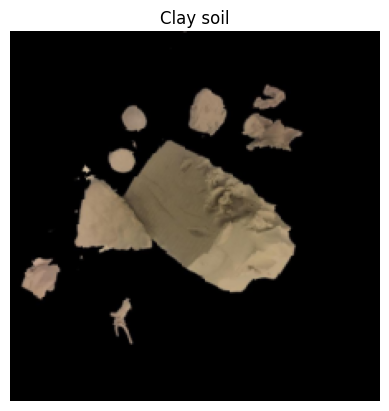

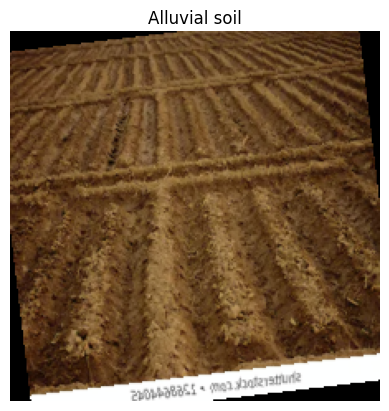

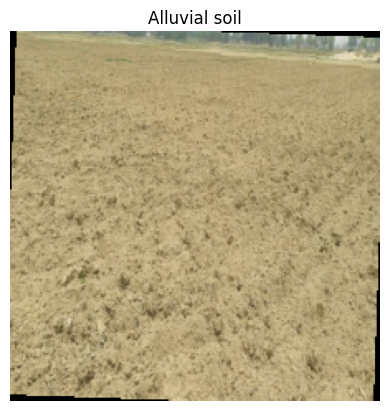

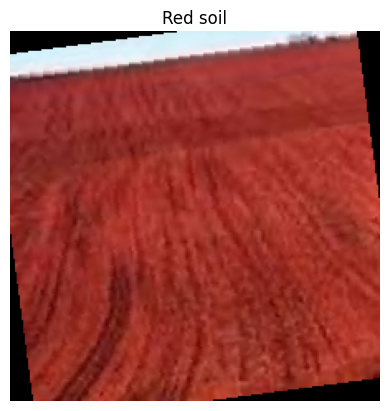

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display an image
def imshow(img, title):
    # unnormalize
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Get a batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Display the first 4 images from the batch
for i in range(4):
    imshow(images[i], title=train_dataset.classes[labels[i]])

In [8]:
# Soil Types dataset (e.g., for additional experiments)
soil_types_dir = '/kaggle/input/soil-types/Soil types'
soil_types_dataset = ImageFolder(root=soil_types_dir, transform=test_transforms)

print("Soil Types Classes:", soil_types_dataset.classes)
print("Number of images in Soil Types dataset:", len(soil_types_dataset))

Soil Types Classes: ['Black Soil', 'Cinder Soil', 'Laterite Soil', 'Peat Soil', 'Yellow Soil']
Number of images in Soil Types dataset: 156


# Step 3: Soil Classification Module Using Deep Learning (PyTorch)

## 3.1 Convolutional Neural Networks

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        # Convolutional Block 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1   = nn.BatchNorm2d(16)
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Convolutional Block 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(32)
        
        # Convolutional Block 3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3   = nn.BatchNorm2d(64)
        
        # After three poolings: image size reduces from 224x224 -> 112x112 -> 56x56 -> 28x28
        self.fc1   = nn.Linear(64 * 28 * 28, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2   = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        # Flatten the tensor for the fully connected layers
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Verify the architecture with the number of classes from the train dataset:
num_classes = len(train_dataset.classes)  # e.g., 4 classes for Alluvial, Black, Clay, Red soils
model_custom = CustomCNN(num_classes=num_classes)
print(model_custom)

CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=50176, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
)


In [10]:
# Set device: GPU enabled in Kaggle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_custom = model_custom.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_custom.parameters(), lr=1e-3)

In [11]:
num_epochs = 15  # Adjust number of epochs based on your experimentation

for epoch in range(num_epochs):
    model_custom.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Clear gradients
        
        # Forward pass
        outputs = model_custom(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and update weights
        loss.backward()
        optimizer.step()
        
        # Accumulate loss and compute accuracy
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

Epoch [1/15], Loss: 4.8053, Accuracy: 67.05%
Epoch [2/15], Loss: 0.5072, Accuracy: 81.72%
Epoch [3/15], Loss: 0.4396, Accuracy: 82.87%
Epoch [4/15], Loss: 0.3930, Accuracy: 81.64%
Epoch [5/15], Loss: 0.4264, Accuracy: 81.72%
Epoch [6/15], Loss: 0.4277, Accuracy: 82.30%
Epoch [7/15], Loss: 0.4293, Accuracy: 83.52%
Epoch [8/15], Loss: 0.4203, Accuracy: 83.11%
Epoch [9/15], Loss: 0.3402, Accuracy: 85.00%
Epoch [10/15], Loss: 0.3575, Accuracy: 84.10%
Epoch [11/15], Loss: 0.4009, Accuracy: 83.85%
Epoch [12/15], Loss: 0.3555, Accuracy: 83.52%
Epoch [13/15], Loss: 0.3377, Accuracy: 86.64%
Epoch [14/15], Loss: 0.3564, Accuracy: 85.33%
Epoch [15/15], Loss: 0.3919, Accuracy: 85.33%


In [12]:
model_custom.eval()  # Set model to evaluation mode
correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_custom(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 88.82%


## 3.2 Helper Function for Training and Evaluation

In [13]:
def train_and_evaluate(model, optimizer, criterion, num_epochs, train_loader, test_loader, device):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
    
    # Evaluate on test set
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_acc = 100 * correct_test / total_test
    print(f"Test Accuracy: {test_acc:.2f}%")

## 3.3 ResNet18 Model

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define ResNet18 model (pretrained)
resnet_model = models.resnet18(pretrained=True)
num_features = resnet_model.fc.in_features  # number of features in the last layer
num_classes = len(train_dataset.classes)      # e.g., 4 soil types
resnet_model.fc = nn.Linear(num_features, num_classes)  # replace final layer
resnet_model = resnet_model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(resnet_model.parameters(), lr=1e-4)

print("Training ResNet18 model...")
train_and_evaluate(resnet_model, optimizer_resnet, criterion, num_epochs=10, 
                   train_loader=train_loader, test_loader=test_loader, device=device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 173MB/s] 


Training ResNet18 model...
Epoch [1/10], Loss: 0.4270, Accuracy: 85.16%
Epoch [2/10], Loss: 0.1160, Accuracy: 96.07%
Epoch [3/10], Loss: 0.0898, Accuracy: 97.70%
Epoch [4/10], Loss: 0.0530, Accuracy: 98.77%
Epoch [5/10], Loss: 0.0837, Accuracy: 97.79%
Epoch [6/10], Loss: 0.0543, Accuracy: 98.36%
Epoch [7/10], Loss: 0.0390, Accuracy: 98.77%
Epoch [8/10], Loss: 0.0266, Accuracy: 99.26%
Epoch [9/10], Loss: 0.0272, Accuracy: 99.26%
Epoch [10/10], Loss: 0.0196, Accuracy: 99.51%
Test Accuracy: 100.00%


## 3.4 EfficientNet-B0 Model

In [15]:
# Using torchvision's EfficientNet-B0
efficientnet_model = models.efficientnet_b0(pretrained=True)
# The classifier is typically a Sequential with Dropout and Linear; we replace the final Linear layer.
num_features = efficientnet_model.classifier[1].in_features
efficientnet_model.classifier[1] = nn.Linear(num_features, num_classes)
efficientnet_model = efficientnet_model.to(device)

# Loss and optimizer
optimizer_efficientnet = optim.Adam(efficientnet_model.parameters(), lr=1e-4)

print("Training EfficientNet-B0 model...")
train_and_evaluate(efficientnet_model, optimizer_efficientnet, criterion, num_epochs=10, 
                   train_loader=train_loader, test_loader=test_loader, device=device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 124MB/s] 


Training EfficientNet-B0 model...
Epoch [1/10], Loss: 0.8728, Accuracy: 74.34%
Epoch [2/10], Loss: 0.3396, Accuracy: 91.48%
Epoch [3/10], Loss: 0.2124, Accuracy: 93.28%
Epoch [4/10], Loss: 0.1239, Accuracy: 96.80%
Epoch [5/10], Loss: 0.1122, Accuracy: 96.97%
Epoch [6/10], Loss: 0.0937, Accuracy: 97.54%
Epoch [7/10], Loss: 0.0774, Accuracy: 98.36%
Epoch [8/10], Loss: 0.0604, Accuracy: 97.87%
Epoch [9/10], Loss: 0.0511, Accuracy: 98.77%
Epoch [10/10], Loss: 0.0483, Accuracy: 98.77%
Test Accuracy: 100.00%


## 3.5 ViT Model (ViT = Vision Transformer)

In [16]:
import timm

# Create a ViT model (e.g., 'vit_base_patch16_224') with pretrained weights
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)
num_features = vit_model.head.in_features
vit_model.head = nn.Linear(num_features, num_classes)
vit_model = vit_model.to(device)

# Loss and optimizer
optimizer_vit = optim.Adam(vit_model.parameters(), lr=1e-4)

print("Training Vision Transformer (ViT) model...")
train_and_evaluate(vit_model, optimizer_vit, criterion, num_epochs=10, 
                   train_loader=train_loader, test_loader=test_loader, device=device)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Training Vision Transformer (ViT) model...
Epoch [1/10], Loss: 0.5324, Accuracy: 78.85%
Epoch [2/10], Loss: 0.2712, Accuracy: 90.74%
Epoch [3/10], Loss: 0.1824, Accuracy: 93.52%
Epoch [4/10], Loss: 0.0942, Accuracy: 96.89%
Epoch [5/10], Loss: 0.1261, Accuracy: 95.16%
Epoch [6/10], Loss: 0.0585, Accuracy: 97.70%
Epoch [7/10], Loss: 0.0546, Accuracy: 98.03%
Epoch [8/10], Loss: 0.0671, Accuracy: 98.11%
Epoch [9/10], Loss: 0.0469, Accuracy: 98.52%
Epoch [10/10], Loss: 0.0209, Accuracy: 99.43%
Test Accuracy: 98.24%


# Step 4: Crop Recommendation Module Using an MLP

In [17]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [18]:
# 1. Load the Crop Recommendation Dataset
df = pd.read_csv('/kaggle/input/crop-recommendation-dataset/Crop_recommendation.csv')
print("First few rows of the dataset:")
print(df.head())
print("Dataset info:")
print(df.info())

First few rows of the dataset:
    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice
Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), obj

In [19]:
# 2. Preprocessing:
#    - Our target is the 'label' column (the recommended crop).
#    - The original features include: N, P, K, temperature, humidity, ph, rainfall.
#    - We simulate a soil type (which in a deployed system comes from the image classification module).

np.random.seed(42)
df['soil_type'] = np.random.randint(0, 4, size=len(df))
print("\nValue counts for simulated soil_type:")
print(df['soil_type'].value_counts())

# One-hot encode the soil_type column
soil_type_dummies = pd.get_dummies(df['soil_type'], prefix='soil')
df = pd.concat([df.drop('soil_type', axis=1), soil_type_dummies], axis=1)


Value counts for simulated soil_type:
soil_type
0    578
1    545
2    543
3    534
Name: count, dtype: int64


In [20]:
# 3. Separate features and target.
#    The original features: N, P, K, temperature, humidity, ph, rainfall
#    Plus the one-hot encoded soil type features.
X = df.drop('label', axis=1).values  # Feature matrix
y = df['label'].values               # Crop labels

# Convert crop labels (which are strings) into integer labels using LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("\nUnique crop labels:", le.classes_)


Unique crop labels: ['apple' 'banana' 'blackgram' 'chickpea' 'coconut' 'coffee' 'cotton'
 'grapes' 'jute' 'kidneybeans' 'lentil' 'maize' 'mango' 'mothbeans'
 'mungbean' 'muskmelon' 'orange' 'papaya' 'pigeonpeas' 'pomegranate'
 'rice' 'watermelon']


In [21]:
# 4. Standardize the numerical features.
#    We assume that the first 7 columns are numerical (N, P, K, temperature, humidity, ph, rainfall),
#    and the remaining columns are the one-hot encoded soil type.
scaler = StandardScaler()
X_num = scaler.fit_transform(X[:, :7])
X_cat = X[:, 7:]  # one-hot soil type columns

# Concatenate numerical and categorical features
X_final = np.concatenate([X_num, X_cat], axis=1)

# Convert final feature matrix to float32 to avoid type conversion errors
X_final = X_final.astype(np.float32)
print("\nShape of final feature matrix:", X_final.shape)


Shape of final feature matrix: (2200, 11)


In [22]:
# 5. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_final, y_encoded, test_size=0.2, random_state=42)

In [23]:
# 6. Create a custom PyTorch Dataset for the tabular data
class CropDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CropDataset(X_train, y_train)
test_dataset = CropDataset(X_test, y_test)

# Create DataLoaders for training and testing
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 4.1 Multi Layer Perceptron

In [24]:
# 7. Define the MLP model for Crop Recommendation
class CropRecommendationMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CropRecommendationMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        return self.model(x)

input_dim = X_final.shape[1]  # 7 (numerical) + 4 (soil type one-hot) = 11
hidden_dim = 64               # You may tune this parameter
output_dim = len(le.classes_) # Number of crop classes
print(f"Input dimension: {input_dim}, Output dimension (number of crop classes): {output_dim}")

mlp_model = CropRecommendationMLP(input_dim, hidden_dim, output_dim)
print("MLP model architecture:")
print(mlp_model)

Input dimension: 11, Output dimension (number of crop classes): 22
MLP model architecture:
CropRecommendationMLP(
  (model): Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=22, bias=True)
  )
)


In [25]:
# 8. Set up training: move model to device, define loss and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_model = mlp_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=1e-3)

In [26]:
# 9. Training loop for the MLP model
num_epochs = 50
for epoch in range(num_epochs):
    mlp_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()            # Clear gradients
        outputs = mlp_model(features)      # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                    # Backward pass
        optimizer.step()                   # Update weights
        
        running_loss += loss.item() * features.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = 100 * correct / total
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

Epoch [10/50], Loss: 0.1399, Accuracy: 96.82%
Epoch [20/50], Loss: 0.0581, Accuracy: 98.24%
Epoch [30/50], Loss: 0.0324, Accuracy: 99.20%
Epoch [40/50], Loss: 0.0226, Accuracy: 99.38%
Epoch [50/50], Loss: 0.0187, Accuracy: 99.55%


In [27]:
# 10. Evaluate the MLP model on the test set
mlp_model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = mlp_model(features)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_acc = 100 * correct_test / total_test
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 97.27%


## 4.2 XgBoost Classifier

In [28]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Create and train the XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions and evaluate accuracy
y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Test Accuracy: {:.2f}%".format(acc_xgb * 100))

XGBoost Test Accuracy: 98.64%


## 4.3 LightGBM Classifier

In [29]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

# Create and train the LightGBM classifier
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

# Make predictions and evaluate accuracy
y_pred_lgb = lgb_model.predict(X_test)
acc_lgb = accuracy_score(y_test, y_pred_lgb)
print("LightGBM Test Accuracy: {:.2f}%".format(acc_lgb * 100))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 1760, number of used features: 11
[LightGBM] [Info] Start training from score -3.129264
[LightGBM] [Info] Start training from score -3.103621
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.169004
[LightGBM] [Info] Start training from score -3.182610
[LightGBM] [Info] Start training from score -3.054228
[LightGBM] [Info] Start training from score -3.054228
[LightGBM] [Info] Start training from score -3.018722
[LightGBM] [Info] Start training from score -3.129264
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -2.984433
[LightGBM] [Info] Start training from score -3.103621
[LightGBM] [Info] Start training from score -3.078620
[LightGBM]

## 4.4 TabNet Classifier

In [30]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score

# Create and train the TabNet classifier
tabnet_clf = TabNetClassifier(verbose=1, seed=42)

# Fit the model – here we set max_epochs and other hyperparameters; feel free to tune these.
tabnet_clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric=['accuracy'],
    max_epochs=50,
    patience=5,
    batch_size=32,
    virtual_batch_size=16,
    num_workers=0,
    drop_last=False
)

# Make predictions and evaluate accuracy
y_pred_tabnet = tabnet_clf.predict(X_test)
acc_tabnet = accuracy_score(y_test, y_pred_tabnet)
print("TabNet Test Accuracy: {:.2f}%".format(acc_tabnet * 100))

epoch 0  | loss: 2.92401 | val_0_accuracy: 0.19545 |  0:00:01s
epoch 1  | loss: 2.02608 | val_0_accuracy: 0.58409 |  0:00:03s
epoch 2  | loss: 1.4466  | val_0_accuracy: 0.61136 |  0:00:04s
epoch 3  | loss: 1.1565  | val_0_accuracy: 0.73182 |  0:00:05s
epoch 4  | loss: 0.99828 | val_0_accuracy: 0.80682 |  0:00:07s
epoch 5  | loss: 1.02441 | val_0_accuracy: 0.75909 |  0:00:08s
epoch 6  | loss: 0.8349  | val_0_accuracy: 0.80455 |  0:00:09s
epoch 7  | loss: 0.64934 | val_0_accuracy: 0.875   |  0:00:11s
epoch 8  | loss: 0.55    | val_0_accuracy: 0.87955 |  0:00:12s
epoch 9  | loss: 0.55173 | val_0_accuracy: 0.92727 |  0:00:13s
epoch 10 | loss: 0.50752 | val_0_accuracy: 0.89091 |  0:00:15s
epoch 11 | loss: 0.54445 | val_0_accuracy: 0.88636 |  0:00:16s
epoch 12 | loss: 0.51182 | val_0_accuracy: 0.84545 |  0:00:17s
epoch 13 | loss: 0.47619 | val_0_accuracy: 0.90682 |  0:00:19s
epoch 14 | loss: 0.42666 | val_0_accuracy: 0.92273 |  0:00:20s

Early stopping occurred at epoch 14 with best_epoch = 

# Step 5. Testing for the Crop Recommendation with all models :)

In [31]:
import numpy as np
import torch

# Example custom input:
# Let's say you measured the following:
# N = 90, P = 40, K = 40, temperature = 20°C, humidity = 80%, ph = 6.5, rainfall = 200 mm
# And assume your soil classification model predicts soil type = 1.
# The one-hot encoding for soil type 1 (assuming 4 types: 0, 1, 2, 3) would be: [0, 1, 0, 0]

# Create the raw input vector:
custom_raw = np.array([[90, 40, 40, 20, 80, 6.5, 200]])  # shape (1,7)

# Scale the numerical features using the previously fitted scaler:
custom_num = scaler.transform(custom_raw)  # shape (1,7)

# One-hot part for soil type (predicted by your image model):
custom_soil = np.array([[0, 1, 0, 0]])  # shape (1,4)

# Concatenate to form the final feature vector:
custom_input = np.concatenate([custom_num, custom_soil], axis=1)  # shape (1, 11)
custom_input = custom_input.astype(np.float32)

# Convert to a torch tensor:
custom_tensor = torch.tensor(custom_input, dtype=torch.float32).to(device)

## 5.1 Using Multi Layer Perceptron :)

In [32]:
# Now, choose one of your trained crop recommendation models for prediction.
# For example, using the MLP model:
mlp_model.eval()
with torch.no_grad():
    output = mlp_model(custom_tensor)
    _, predicted_label = torch.max(output, 1)
    
# Convert the predicted label back to the crop name:
predicted_crop = le.inverse_transform(predicted_label.cpu().numpy())
print("Predicted Crop:", predicted_crop[0])

Predicted Crop: rice


## 5.2 Using XbBoost

In [33]:
# custom_input is a NumPy array of shape (1, 11) already scaled/processed
y_pred_xgb = xgb_model.predict(custom_input)
predicted_crop_xgb = le.inverse_transform(y_pred_xgb)
print("XGBoost Predicted Crop:", predicted_crop_xgb[0])

XGBoost Predicted Crop: rice


## 5.3 Using LightGBM

In [34]:
y_pred_lgb = lgb_model.predict(custom_input)
predicted_crop_lgb = le.inverse_transform(y_pred_lgb)
print("LightGBM Predicted Crop:", predicted_crop_lgb[0])

LightGBM Predicted Crop: jute


## 5.4 Using TabNet

In [35]:
y_pred_tabnet = tabnet_clf.predict(custom_input)
predicted_crop_tabnet = le.inverse_transform(y_pred_tabnet)
print("TabNet Predicted Crop:", predicted_crop_tabnet[0])

TabNet Predicted Crop: rice


## 5.5 Using Combinely Models and Random Set of Data

In [36]:
import numpy as np
import torch

# Define several custom inputs.
# Each row: [N, P, K, temperature, humidity, ph, rainfall] followed by one-hot soil type encoding (4 values)
# (Remember: these inputs must be processed with the same scaler as during training.)

custom_samples_raw = np.array([
    [90, 40, 40, 20, 80, 6.5, 200],   # Sample 1 values
    [80, 30, 50, 25, 70, 6.2, 150],   # Sample 2 values
    [70, 20, 30, 30, 60, 7.0, 100]    # Sample 3 values
])

# Assume these samples have different predicted soil types:
# Sample 1: soil type = 1 -> [0,1,0,0]
# Sample 2: soil type = 0 -> [1,0,0,0]
# Sample 3: soil type = 2 -> [0,0,1,0]
soil_one_hot = np.array([
    [0, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 1, 0]
])

# Scale the numerical part:
custom_samples_num = scaler.transform(custom_samples_raw)  # shape (3,7)

# Concatenate numerical and categorical parts:
custom_samples = np.concatenate([custom_samples_num, soil_one_hot], axis=1)
custom_samples = custom_samples.astype(np.float32)  # shape (3,11)

# Convert to torch tensor for PyTorch models:
custom_tensor = torch.tensor(custom_samples, dtype=torch.float32).to(device)

# Get predictions from each model:

# 1. MLP Model
mlp_model.eval()
with torch.no_grad():
    output_mlp = mlp_model(custom_tensor)
    _, predicted_label_mlp = torch.max(output_mlp, 1)
predicted_crop_mlp = le.inverse_transform(predicted_label_mlp.cpu().numpy())

# 2. XGBoost Model (expects numpy array)
y_pred_xgb = xgb_model.predict(custom_samples)
predicted_crop_xgb = le.inverse_transform(y_pred_xgb)

# 3. LightGBM Model
y_pred_lgb = lgb_model.predict(custom_samples)
predicted_crop_lgb = le.inverse_transform(y_pred_lgb)

# 4. TabNet Model (expects numpy array)
y_pred_tabnet = tabnet_clf.predict(custom_samples)
predicted_crop_tabnet = le.inverse_transform(y_pred_tabnet)

# Print the predictions for each sample:
for i in range(len(custom_samples)):
    print(f"Sample {i+1}:")
    print(f"  MLP Prediction:      {predicted_crop_mlp[i]}")
    print(f"  XGBoost Prediction:  {predicted_crop_xgb[i]}")
    print(f"  LightGBM Prediction: {predicted_crop_lgb[i]}")
    print(f"  TabNet Prediction:   {predicted_crop_tabnet[i]}")
    print("----------")

Sample 1:
  MLP Prediction:      rice
  XGBoost Prediction:  rice
  LightGBM Prediction: jute
  TabNet Prediction:   rice
----------
Sample 2:
  MLP Prediction:      jute
  XGBoost Prediction:  jute
  LightGBM Prediction: coffee
  TabNet Prediction:   jute
----------
Sample 3:
  MLP Prediction:      coffee
  XGBoost Prediction:  maize
  LightGBM Prediction: maize
  TabNet Prediction:   mango
----------


The major thing here, is the One Hot Encoding for the Soil Classification and in this we know that these are the randomly given. We need to do the soil classification from the image then we have to comeback here for the crop prediction.

# Step 6: Testing the Soil Classification Model

In [37]:
from torchvision.datasets import ImageFolder
soil_train_dataset = ImageFolder(root=train_dir, transform=train_transforms)

## 6.1 Testing on Alluvial Soil

Soil Classification Predictions for the sample image:
Custom CNN          Prediction: Alluvial soil
ResNet18            Prediction: Alluvial soil
EfficientNet-B0     Prediction: Alluvial soil
ViT                 Prediction: Alluvial soil


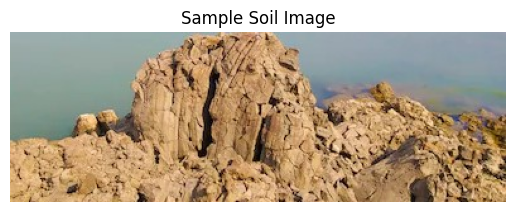

In [38]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Make sure you're using the ImageFolder dataset for soil classification
# For example, if you already defined:
# soil_train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
soil_classes = soil_train_dataset.classes  # This holds the list of class names

# Define a helper function to predict soil type from an image using a given model
def predict_soil_type(image_path, model, transform, class_names):
    model.eval()  # Set model to evaluation mode
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    predicted_class = class_names[predicted.item()]
    return predicted_class

# Path to a sample soil image (update this path as necessary)
sample_image_path = '/kaggle/input/soil-image-dataset/Dataset/test/Alluvial soil/Alluvial_9.jpg'

# Predict using each model
pred_custom = predict_soil_type(sample_image_path, model_custom, test_transforms, soil_classes)
pred_resnet = predict_soil_type(sample_image_path, resnet_model, test_transforms, soil_classes)
pred_efficientnet = predict_soil_type(sample_image_path, efficientnet_model, test_transforms, soil_classes)
pred_vit = predict_soil_type(sample_image_path, vit_model, test_transforms, soil_classes)

print("Soil Classification Predictions for the sample image:")
print("Custom CNN          Prediction:", pred_custom)
print("ResNet18            Prediction:", pred_resnet)
print("EfficientNet-B0     Prediction:", pred_efficientnet)
print("ViT                 Prediction:", pred_vit)

# Optionally, visualize the sample image
img = Image.open(sample_image_path)
plt.imshow(img)
plt.title("Sample Soil Image")
plt.axis("off")
plt.show()

## 6.2 Testing on Black Soil

Soil Classification Predictions for the sample image:
Custom CNN          Prediction: Black Soil
ResNet18            Prediction: Black Soil
EfficientNet-B0     Prediction: Black Soil
ViT                 Prediction: Black Soil


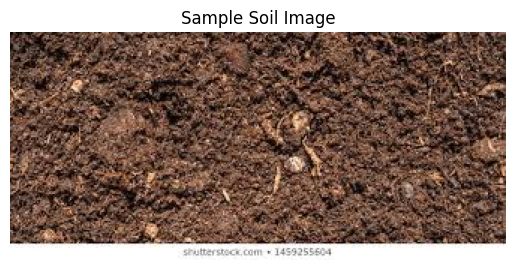

In [39]:
sample_image_path = '/kaggle/input/soil-image-dataset/Dataset/test/Black Soil/Black_2.jpg'

# Predict using each model
pred_custom = predict_soil_type(sample_image_path, model_custom, test_transforms, soil_classes)
pred_resnet = predict_soil_type(sample_image_path, resnet_model, test_transforms, soil_classes)
pred_efficientnet = predict_soil_type(sample_image_path, efficientnet_model, test_transforms, soil_classes)
pred_vit = predict_soil_type(sample_image_path, vit_model, test_transforms, soil_classes)

print("Soil Classification Predictions for the sample image:")
print("Custom CNN          Prediction:", pred_custom)
print("ResNet18            Prediction:", pred_resnet)
print("EfficientNet-B0     Prediction:", pred_efficientnet)
print("ViT                 Prediction:", pred_vit)

# Optionally, visualize the sample image
img = Image.open(sample_image_path)
plt.imshow(img)
plt.title("Sample Soil Image")
plt.axis("off")
plt.show()

## 6.3 Testing on Clay Soil

Soil Classification Predictions for the sample image:
Custom CNN          Prediction: Clay soil
ResNet18            Prediction: Clay soil
EfficientNet-B0     Prediction: Clay soil
ViT                 Prediction: Clay soil


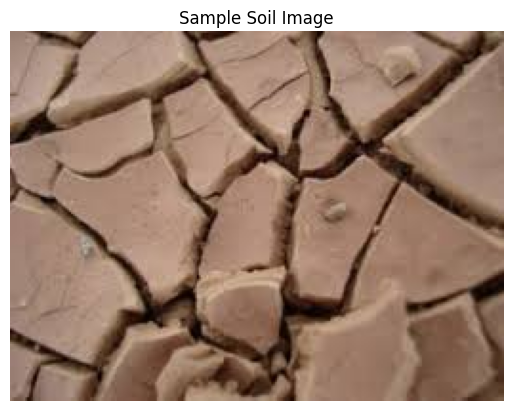

In [40]:
sample_image_path = '/kaggle/input/soil-image-dataset/Dataset/test/Clay soil/Clay_9.jpg'

# Predict using each model
pred_custom = predict_soil_type(sample_image_path, model_custom, test_transforms, soil_classes)
pred_resnet = predict_soil_type(sample_image_path, resnet_model, test_transforms, soil_classes)
pred_efficientnet = predict_soil_type(sample_image_path, efficientnet_model, test_transforms, soil_classes)
pred_vit = predict_soil_type(sample_image_path, vit_model, test_transforms, soil_classes)

print("Soil Classification Predictions for the sample image:")
print("Custom CNN          Prediction:", pred_custom)
print("ResNet18            Prediction:", pred_resnet)
print("EfficientNet-B0     Prediction:", pred_efficientnet)
print("ViT                 Prediction:", pred_vit)

# Optionally, visualize the sample image
img = Image.open(sample_image_path)
plt.imshow(img)
plt.title("Sample Soil Image")
plt.axis("off")
plt.show()

## 6.4 Testing on Red Soil

Soil Classification Predictions for the sample image:
Custom CNN          Prediction: Red soil
ResNet18            Prediction: Red soil
EfficientNet-B0     Prediction: Red soil
ViT                 Prediction: Red soil


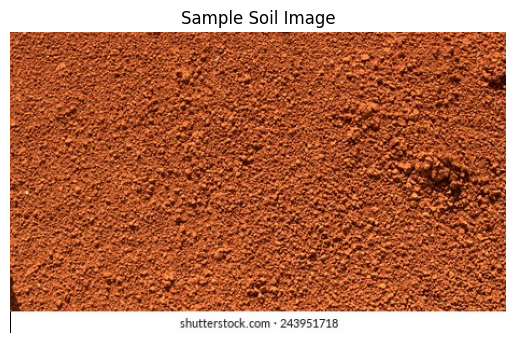

In [41]:
sample_image_path = '/kaggle/input/soil-image-dataset/Dataset/test/Red soil/Copy of image-red-soil-texture-260nw-243951718.jpg'

# Predict using each model
pred_custom = predict_soil_type(sample_image_path, model_custom, test_transforms, soil_classes)
pred_resnet = predict_soil_type(sample_image_path, resnet_model, test_transforms, soil_classes)
pred_efficientnet = predict_soil_type(sample_image_path, efficientnet_model, test_transforms, soil_classes)
pred_vit = predict_soil_type(sample_image_path, vit_model, test_transforms, soil_classes)

print("Soil Classification Predictions for the sample image:")
print("Custom CNN          Prediction:", pred_custom)
print("ResNet18            Prediction:", pred_resnet)
print("EfficientNet-B0     Prediction:", pred_efficientnet)
print("ViT                 Prediction:", pred_vit)

# Optionally, visualize the sample image
img = Image.open(sample_image_path)
plt.imshow(img)
plt.title("Sample Soil Image")
plt.axis("off")
plt.show()

# Step 7: Pipeline for the Crop Recommendation [From Soil Classification]

Predicted Soil Type from image: Alluvial soil
Final Input Vector Shape: (1, 11)
Recommended Crop: rice


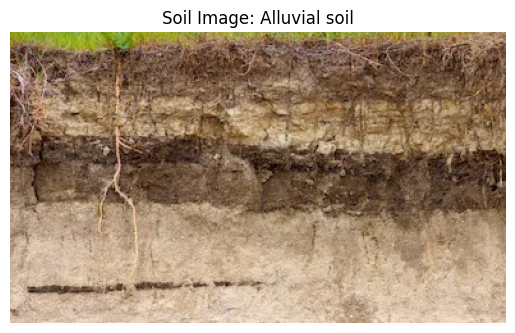

In [42]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

# --- Helper Functions ---

def predict_soil_type(image_path, model, transform):
    """
    Predict the soil type from an image using a given soil classification model.
    Returns the integer label.
    """
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    return predicted.item()

def one_hot_encode(label, num_classes):
    """
    Convert a categorical label (integer) into a one-hot encoded vector.
    """
    return np.eye(num_classes)[label]

# --- Pipeline Implementation ---

# Step A: Soil Classification
# ---------------------------------
# Provide the path to your soil image.
sample_soil_image = '/kaggle/input/soil-image-dataset/Dataset/test/Alluvial soil/Alluvial_23.jpg'

# Predict soil type using your soil classification model.
# (You can use model_custom, resnet_model, etc. Here we use model_custom.)
soil_label = predict_soil_type(sample_soil_image, model_custom, test_transforms)
# Retrieve the soil type name from your ImageFolder dataset
soil_type_name = soil_train_dataset.classes[soil_label]
print("Predicted Soil Type from image:", soil_type_name)

# Convert the predicted soil label into a one-hot vector.
# Assume there are 4 soil classes.
soil_one_hot = one_hot_encode(soil_label, num_classes=4)  # Shape: (4,)
# Reshape to (1,4) for concatenation later.
soil_one_hot = soil_one_hot.reshape(1, -1)

# Step B: Gather Numerical Features for Crop Recommendation
# ---------------------------------
# These numerical features are the measured soil parameters.
# For example, assume:
# N = 90, P = 40, K = 40, temperature = 20°C, humidity = 80%, ph = 6.5, rainfall = 200 mm.
numerical_features = np.array([[90, 40, 40, 20, 80, 6.5, 200]])  # Shape: (1,7)

# Scale these numerical features using the scaler fitted during training.
numerical_features_scaled = scaler.transform(numerical_features)  # Shape: (1,7)

# Step C: Create the Final Input Vector for Crop Recommendation
# ---------------------------------
# Concatenate the scaled numerical features (7 values) with the one-hot soil type (4 values)
final_input = np.concatenate([numerical_features_scaled, soil_one_hot], axis=1).astype(np.float32)
print("Final Input Vector Shape:", final_input.shape)  # Expect (1, 11)

# Convert the final input to a torch tensor (for PyTorch model)
final_tensor = torch.tensor(final_input, dtype=torch.float32).to(device)

# Step D: Crop Recommendation Prediction using the MLP Model
# ---------------------------------
mlp_model.eval()
with torch.no_grad():
    crop_output = mlp_model(final_tensor)
    _, crop_pred_label = torch.max(crop_output, 1)

# Decode the predicted label back to a crop name using the LabelEncoder
predicted_crop = le.inverse_transform(crop_pred_label.cpu().numpy())
print("Recommended Crop:", predicted_crop[0])

# (Optional) Visualize the soil image
img = Image.open(sample_soil_image)
plt.imshow(img)
plt.title("Soil Image: " + soil_type_name)
plt.axis("off")
plt.show()

# Step 8: Multi Soil Classification and Multi Crop Recommendation

In [43]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Helper function: predict soil type from an image using a given soil classification model
def predict_soil_type(image_path, model, transform):
    model.eval()  # Set model to evaluation mode
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    return predicted.item()  # Returns an integer label

# Helper function: one-hot encode a categorical label into a vector
def one_hot_encode(label, num_classes):
    return np.eye(num_classes)[label]

# ---------------------------
# Assume the following lists are defined:
# Soil classification models and their names:
soil_classification_models = [model_custom, resnet_model, efficientnet_model, vit_model]
soil_model_names = ["Custom CNN", "ResNet18", "EfficientNet-B0", "ViT"]

# Crop recommendation models and their names:
crop_recommendation_models = [mlp_model, xgb_model, lgb_model, tabnet_clf]
crop_model_names = ["MLP", "XGBoost", "LightGBM", "TabNet"]

# The ImageFolder dataset for soil classification, which has .classes (e.g., ["Alluvial soil", "Black Soil", "Clay soil", "Red soil"])
# For example, if you created it as:
# soil_train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
soil_classes = soil_train_dataset.classes  # List of soil type names
num_soil_classes = len(soil_classes)  # e.g., 4

# A sample soil image to test (update this path as necessary):
sample_soil_image = '/kaggle/input/soil-image-dataset/Dataset/test/Alluvial soil/Alluvial_23.jpg'

# Simulated numerical features for crop recommendation: 
# [N, P, K, temperature, humidity, ph, rainfall]
numerical_features = np.array([[90, 40, 40, 20, 80, 6.5, 200]])  # Shape: (1,7)
# Scale these numerical features using the same scaler used during training:
numerical_features_scaled = scaler.transform(numerical_features)  # Shape: (1,7)

# ---------------------------
# Loop over soil classification models to test their predictions
print("----- Soil Classification Predictions -----")
for model, name in zip(soil_classification_models, soil_model_names):
    soil_label = predict_soil_type(sample_soil_image, model, test_transforms)
    soil_name = soil_classes[soil_label]
    print(f"{name} predicts soil type: {soil_name}")

# ---------------------------
# Loop over each soil classification model and then over crop recommendation models
print("\n----- Integrated Crop Recommendation Predictions -----")
for soil_model, soil_model_name in zip(soil_classification_models, soil_model_names):
    # Get soil type prediction from the current soil model
    soil_label = predict_soil_type(sample_soil_image, soil_model, test_transforms)
    soil_name = soil_classes[soil_label]
    # Convert the soil label to one-hot encoding (e.g., for 4 classes)
    soil_one_hot = one_hot_encode(soil_label, num_soil_classes).reshape(1, -1)  # Shape: (1,4)
    
    # Create the final input vector for crop recommendation:
    # Concatenate scaled numerical features (7 values) with one-hot encoded soil type (4 values) -> (1,11)
    final_input = np.concatenate([numerical_features_scaled, soil_one_hot], axis=1).astype(np.float32)
    
    print(f"\nUsing Soil Classification from {soil_model_name} (Predicted: {soil_name}):")
    
    # Loop over each crop recommendation model:
    for crop_model, crop_model_name in zip(crop_recommendation_models, crop_model_names):
        # For PyTorch models (e.g., mlp_model) use torch tensor; for others use numpy array
        if isinstance(crop_model, torch.nn.Module):
            crop_model.eval()
            final_tensor = torch.tensor(final_input, dtype=torch.float32).to(device)
            with torch.no_grad():
                crop_output = crop_model(final_tensor)
                _, crop_pred_label = torch.max(crop_output, 1)
            predicted_crop = le.inverse_transform(crop_pred_label.cpu().numpy())
        else:
            # For XGBoost, LightGBM, and TabNet which work on numpy arrays:
            crop_pred = crop_model.predict(final_input)
            predicted_crop = le.inverse_transform(crop_pred)
            
        print(f"  {crop_model_name} recommends crop: {predicted_crop[0]}")

----- Soil Classification Predictions -----
Custom CNN predicts soil type: Alluvial soil
ResNet18 predicts soil type: Alluvial soil
EfficientNet-B0 predicts soil type: Alluvial soil
ViT predicts soil type: Alluvial soil

----- Integrated Crop Recommendation Predictions -----

Using Soil Classification from Custom CNN (Predicted: Alluvial soil):
  MLP recommends crop: rice
  XGBoost recommends crop: rice
  LightGBM recommends crop: jute
  TabNet recommends crop: rice

Using Soil Classification from ResNet18 (Predicted: Alluvial soil):
  MLP recommends crop: rice
  XGBoost recommends crop: rice
  LightGBM recommends crop: jute
  TabNet recommends crop: rice

Using Soil Classification from EfficientNet-B0 (Predicted: Alluvial soil):
  MLP recommends crop: rice
  XGBoost recommends crop: rice
  LightGBM recommends crop: jute
  TabNet recommends crop: rice

Using Soil Classification from ViT (Predicted: Alluvial soil):
  MLP recommends crop: rice
  XGBoost recommends crop: rice
  LightGBM r

# Step 9: Pipeline as per Report => Final Crop Recommendation

----- Test: Strongly Acidic Scenario -----
Predicted Soil Type from image: Alluvial soil
Recommended Crop: Not suitable for any crop
For the given input (pH ~3.7), recommended crop: Not suitable for any crop

----- Test: Neutral pH Scenario -----
Predicted Soil Type from image: Alluvial soil
Recommended Crop: Rice
For the given input (pH ~6.5), recommended crop: Rice


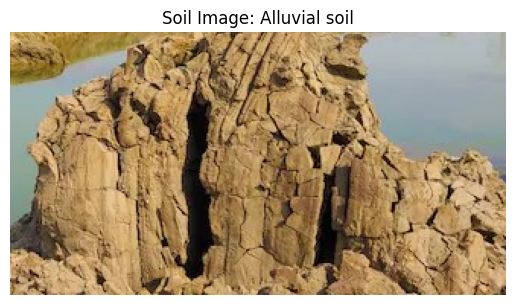

In [44]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

# ---------------------------
# Helper Functions
# ---------------------------

def predict_soil_type(image_path, model, transform):
    """
    Predict the soil type from an image.
    Returns the integer label.
    """
    model.eval()  # Set the model to evaluation mode
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    return predicted.item()

def one_hot_encode(label, num_classes):
    """
    Convert an integer label into a one-hot encoded vector.
    """
    return np.eye(num_classes)[label]

def rule_based_crop_recommendation(soil_numerical_values, soil_label):
    """
    Given numerical soil measurements and a soil type label,
    apply threshold-based rules to recommend a crop.
    
    Expected order of soil_numerical_values: [N, P, K, temperature, humidity, pH, rainfall]
    """
    # Extract values
    N = soil_numerical_values[0, 0]
    P = soil_numerical_values[0, 1]
    K = soil_numerical_values[0, 2]
    pH = soil_numerical_values[0, 5]
    
    # Rule 1: pH thresholds
    if pH < 4.0 or pH > 7.5:
        return "Not suitable for any crop"
    
    # Rule 2: Nutrient thresholds (set arbitrary thresholds; adjust based on domain knowledge)
    # For example, require minimum values: N>=50, P>=20, K>=20 for a viable crop.
    if N < 50 or P < 20 or K < 20:
        return "Nutrients deficient - not suitable for any crop"
    
    # Rule 3: Based on soil type.
    # Assume soil_train_dataset.classes returns a list like: ["Alluvial soil", "Black Soil", "Clay soil", "Red soil"]
    soil_type = soil_train_dataset.classes[soil_label]
    
    if soil_type == "Alluvial soil":
        return "Rice"       # For example, Alluvial soils are ideal for rice.
    elif soil_type == "Black Soil":
        return "Maize"      # Black soils are often used for maize.
    elif soil_type == "Clay soil":
        return "Wheat"      # Clay soils can be used for wheat.
    elif soil_type == "Red soil":
        return "Vegetables" # Red soils may be better for vegetable crops.
    else:
        return "Crop recommendation unclear"

# ---------------------------
# Integrated Pipeline Function
# ---------------------------

def integrated_rule_based_recommendation(soil_image_path, soil_numerical_values):
    """
    End-to-end pipeline that:
      1. Takes a soil image and numerical measurements.
      2. Predicts the soil type using a soil classification model.
      3. Applies rule-based thresholds on pH and nutrients.
      4. Recommends a crop.
    """
    # Step A: Soil Classification
    soil_label = predict_soil_type(soil_image_path, model_custom, test_transforms)
    soil_type_name = soil_train_dataset.classes[soil_label]
    print("Predicted Soil Type from image:", soil_type_name)
    
    # (Optional) If you wish to one-hot encode the soil type for other pipelines,
    # you can do that. For our rule-based decision, we just need the label.
    
    # Step B: Use the raw numerical features (assumed to be in order: N, P, K, temperature, humidity, pH, rainfall)
    # Here we assume the user inputs raw values (without scaling) since thresholds are defined on raw values.
    # (If your training data used scaled values, you might need to inverse-transform or define thresholds on scaled values.)
    
    # Step C: Apply rule-based logic to recommend a crop
    recommended_crop = rule_based_crop_recommendation(soil_numerical_values, soil_label)
    print("Recommended Crop:", recommended_crop)
    return recommended_crop

# ---------------------------
# Example Usage
# ---------------------------

# Example 1: Strongly acidic soil scenario
# Numerical measurements: [N, P, K, temperature, humidity, pH, rainfall]
# For instance, pH=3.7 (strongly acidic) even if other nutrient values are adequate.
soil_numerical_values_acidic = np.array([[90, 40, 40, 20, 80, 3.7, 200]])  # pH is 3.7
soil_image_path = '/kaggle/input/soil-image-dataset/Dataset/test/Alluvial soil/Alluvial_11.jpg'

print("----- Test: Strongly Acidic Scenario -----")
recommended_crop_acidic = integrated_rule_based_recommendation(soil_image_path, soil_numerical_values_acidic)
print("For the given input (pH ~3.7), recommended crop:", recommended_crop_acidic)

# Example 2: Neutral pH scenario with sufficient nutrients
soil_numerical_values_neutral = np.array([[90, 40, 40, 20, 80, 6.5, 200]])  # pH is 6.5, within acceptable range
print("\n----- Test: Neutral pH Scenario -----")
recommended_crop_neutral = integrated_rule_based_recommendation(soil_image_path, soil_numerical_values_neutral)
print("For the given input (pH ~6.5), recommended crop:", recommended_crop_neutral)

# (Optional) Visualize the sample soil image for reference
img = Image.open(soil_image_path)
plt.imshow(img)
plt.title("Soil Image: " + soil_train_dataset.classes[predict_soil_type(soil_image_path, model_custom, test_transforms)])
plt.axis("off")
plt.show()

----- Running Crop Recommendation Tests -----

Test Case: Strongly acidic (pH=3.7) with adequate nutrients, Alluvial soil
Predicted Soil Type: Alluvial soil
Recommended Crop(s): ['Not suitable for any crop']

Test Case: Highly alkaline (pH=8.0) with adequate nutrients, Black Soil
Predicted Soil Type: Black Soil
Recommended Crop(s): ['Not suitable for any crop']

Test Case: Nutrient deficient (N=40) at neutral pH (6.5), Clay soil
Predicted Soil Type: Clay soil
Recommended Crop(s): ['Nutrients deficient - not suitable for any crop']

Test Case: Optimal conditions for Alluvial soil with high nutrients
Predicted Soil Type: Alluvial soil
Recommended Crop(s): ['Rice', 'Sugarcane']

Test Case: Optimal conditions for Black Soil with high nutrients
Predicted Soil Type: Black Soil
Recommended Crop(s): ['Maize', 'Cotton']

Test Case: Optimal conditions for Clay soil with high nutrients
Predicted Soil Type: Clay soil
Recommended Crop(s): ['Wheat', 'Barley']

Test Case: Optimal conditions for Red s

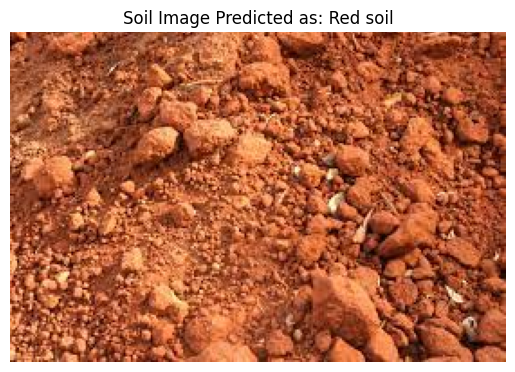

In [45]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

# ---------------------------
# Updated Rule-Based Crop Recommendation Function
# ---------------------------
def rule_based_crop_recommendation(soil_numerical_values, soil_label):
    """
    Given numerical soil measurements (order: [N, P, K, temperature, humidity, pH, rainfall])
    and a soil type label (an integer index), return a list of recommended crops based on thresholds.
    """
    # Extract key values
    N = soil_numerical_values[0, 0]
    P = soil_numerical_values[0, 1]
    K = soil_numerical_values[0, 2]
    pH = soil_numerical_values[0, 5]
    
    # Rule for pH: if too acidic (<4.0) or too alkaline (>7.5), no crop is suitable.
    if pH < 4.0 or pH > 7.5:
        return ["Not suitable for any crop"]
    
    # Rule for nutrient deficiency: if any key nutrient is too low.
    if N < 50 or P < 20 or K < 20:
        return ["Nutrients deficient - not suitable for any crop"]
    
    # Get soil type name from the soil classification dataset
    soil_type = soil_train_dataset.classes[soil_label]
    recommendations = []
    
    # For demonstration, we add multiple recommendations if nutrient levels are very high.
    if soil_type == "Alluvial soil":
        # Moderate conditions: recommend Rice
        recommendations = ["Rice"]
        # If very high nutrients, also recommend Sugarcane (example)
        if N > 100 and P > 50 and K > 50:
            recommendations.append("Sugarcane")
    elif soil_type == "Black Soil":
        recommendations = ["Maize"]
        if N > 100 and P > 50 and K > 50:
            recommendations.append("Cotton")
    elif soil_type == "Clay soil":
        recommendations = ["Wheat"]
        if N > 100 and P > 50 and K > 50:
            recommendations.append("Barley")
    elif soil_type == "Red soil":
        recommendations = ["Vegetables"]
        if N > 100 and P > 50 and K > 50:
            recommendations.append("Pulses")
    else:
        recommendations = ["Crop recommendation unclear"]
    
    return recommendations

# ---------------------------
# Updated Integrated Pipeline (with override option)
# ---------------------------
def integrated_rule_based_recommendation(soil_image_path, soil_numerical_values, override_soil_label=None):
    """
    End-to-end pipeline that:
      1. Takes a soil image and numerical measurements.
      2. Predicts the soil type using the soil classification model,
         or uses override_soil_label if provided.
      3. Applies rule-based thresholds on pH and key nutrients.
      4. Returns a list of recommended crops.
    """
    # If override_soil_label is provided, use it; otherwise predict from image.
    if override_soil_label is None:
        soil_label = predict_soil_type(soil_image_path, model_custom, test_transforms)
    else:
        soil_label = override_soil_label
    
    soil_type_name = soil_train_dataset.classes[soil_label]
    print("Predicted Soil Type:", soil_type_name)
    
    # For rule-based decisions, we assume the numerical features are in raw (unscaled) form.
    # (Adjust thresholds accordingly if you use scaled values.)
    recommended_crops = rule_based_crop_recommendation(soil_numerical_values, soil_label)
    print("Recommended Crop(s):", recommended_crops)
    return recommended_crops

# ---------------------------
# Test Cases
# ---------------------------
# Define a list of test scenarios.
# Each test case is a dictionary with:
# - 'name': a label for the test case.
# - 'numerical': a NumPy array of shape (1,7) representing [N, P, K, temperature, humidity, pH, rainfall].
# - 'override_soil_label': an integer (0,1,2,3) representing a soil type, or None to use the image.
test_cases = [
    {
        "name": "Strongly acidic (pH=3.7) with adequate nutrients, Alluvial soil",
        "numerical": np.array([[90, 40, 40, 20, 80, 3.7, 200]]),
        "override_soil_label": 0  # Alluvial soil
    },
    {
        "name": "Highly alkaline (pH=8.0) with adequate nutrients, Black Soil",
        "numerical": np.array([[90, 40, 40, 25, 70, 8.0, 150]]),
        "override_soil_label": 1  # Black Soil
    },
    {
        "name": "Nutrient deficient (N=40) at neutral pH (6.5), Clay soil",
        "numerical": np.array([[40, 40, 40, 20, 80, 6.5, 200]]),
        "override_soil_label": 2  # Clay soil
    },
    {
        "name": "Optimal conditions for Alluvial soil with high nutrients",
        "numerical": np.array([[120, 60, 60, 22, 75, 6.5, 180]]),
        "override_soil_label": 0  # Alluvial soil
    },
    {
        "name": "Optimal conditions for Black Soil with high nutrients",
        "numerical": np.array([[120, 60, 60, 23, 80, 6.5, 170]]),
        "override_soil_label": 1  # Black Soil
    },
    {
        "name": "Optimal conditions for Clay soil with high nutrients",
        "numerical": np.array([[120, 60, 60, 20, 85, 6.5, 160]]),
        "override_soil_label": 2  # Clay soil
    },
    {
        "name": "Optimal conditions for Red soil with high nutrients",
        "numerical": np.array([[120, 60, 60, 21, 80, 6.5, 190]]),
        "override_soil_label": 3  # Red soil
    }
]

# Provide a sample soil image path.
# (The image won't affect the recommendation if override_soil_label is used.)
sample_soil_image = '/kaggle/input/soil-image-dataset/Dataset/test/Red soil/Copy of image15.jpeg'

# Run the tests
print("----- Running Crop Recommendation Tests -----")
for case in test_cases:
    print("\nTest Case:", case["name"])
    # Call the integrated pipeline with the test case values.
    integrated_rule_based_recommendation(sample_soil_image, case["numerical"], override_soil_label=case["override_soil_label"])

# ---------------------------
# (Optional) Visualize one sample image with its predicted soil type from a model (if not overridden)
predicted_soil = predict_soil_type(sample_soil_image, model_custom, test_transforms)
soil_name = soil_train_dataset.classes[predicted_soil]
img = Image.open(sample_soil_image)
plt.imshow(img)
plt.title("Soil Image Predicted as: " + soil_name)
plt.axis("off")
plt.show()

# Step 10: Pipeline Diversion

----- Running Crop Recommendation Tests (Using Image Prediction) -----

Test Case: Strongly acidic (pH=3.7) with adequate nutrients, expected: Not suitable
Predicted Soil Type from image: Red soil
Recommended Crop(s): ['Not suitable for any crop']

Test Case: Highly alkaline (pH=8.0) with adequate nutrients, expected: Not suitable
Predicted Soil Type from image: Red soil
Recommended Crop(s): ['Not suitable for any crop']

Test Case: Nutrient deficient (N=40) at neutral pH (6.5), expected: Nutrients deficient
Predicted Soil Type from image: Red soil
Recommended Crop(s): ['Nutrients deficient - not suitable for any crop']

Test Case: Optimal conditions for Alluvial soil with high nutrients, expected: Rice and Sugarcane
Predicted Soil Type from image: Red soil
Recommended Crop(s): ['Vegetables', 'Pulses']

Test Case: Optimal conditions for Black Soil with high nutrients, expected: Maize and Cotton
Predicted Soil Type from image: Red soil
Recommended Crop(s): ['Vegetables', 'Pulses']

Test

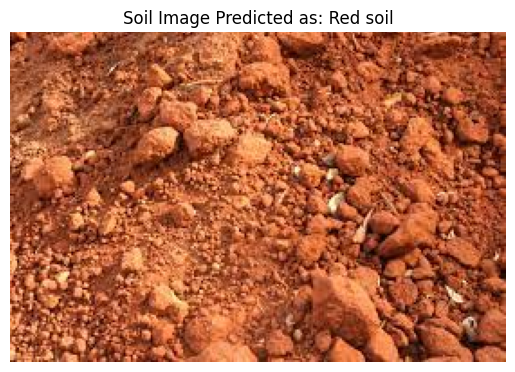

In [46]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

# ---------------------------
# Helper Functions
# ---------------------------

def predict_soil_type(image_path, model, transform):
    """
    Given an image path, predict the soil type using the provided soil classification model.
    Returns the predicted integer label.
    """
    model.eval()  # Set the model to evaluation mode
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    return predicted.item()

def one_hot_encode(label, num_classes):
    """
    Converts an integer label into a one-hot encoded vector of length num_classes.
    """
    return np.eye(num_classes)[label]

def rule_based_crop_recommendation(soil_numerical_values, soil_label):
    """
    Given numerical soil measurements (order: [N, P, K, temperature, humidity, pH, rainfall])
    and a soil type label (an integer index), return a list of recommended crops based on thresholds.
    """
    # Extract key values
    N = soil_numerical_values[0, 0]
    P = soil_numerical_values[0, 1]
    K = soil_numerical_values[0, 2]
    pH = soil_numerical_values[0, 5]
    
    # Rule for pH: if too acidic (<4.0) or too alkaline (>7.5), no crop is suitable.
    if pH < 4.0 or pH > 7.5:
        return ["Not suitable for any crop"]
    
    # Rule for nutrient deficiency: if any key nutrient is too low.
    if N < 50 or P < 20 or K < 20:
        return ["Nutrients deficient - not suitable for any crop"]
    
    # Get soil type name from the soil classification dataset
    soil_type = soil_train_dataset.classes[soil_label]
    recommendations = []
    
    # For demonstration, add multiple recommendations if nutrient levels are very high.
    if soil_type == "Alluvial soil":
        recommendations = ["Rice"]
        if N > 100 and P > 50 and K > 50:
            recommendations.append("Sugarcane")
    elif soil_type == "Black Soil":
        recommendations = ["Maize"]
        if N > 100 and P > 50 and K > 50:
            recommendations.append("Cotton")
    elif soil_type == "Clay soil":
        recommendations = ["Wheat"]
        if N > 100 and P > 50 and K > 50:
            recommendations.append("Barley")
    elif soil_type == "Red soil":
        recommendations = ["Vegetables"]
        if N > 100 and P > 50 and K > 50:
            recommendations.append("Pulses")
    else:
        recommendations = ["Crop recommendation unclear"]
    
    return recommendations

# ---------------------------
# Integrated Pipeline A Function (No override)
# ---------------------------
def integrated_crop_recommendation(soil_image_path, soil_numerical_values):
    """
    Integrated pipeline that:
      1. Takes a soil image and numerical measurements.
      2. Predicts the soil type using the soil classification model.
      3. One-hot encodes the predicted soil type.
      4. Applies the rule-based crop recommendation using numerical features.
    
    Parameters:
      soil_image_path (str): Path to the soil image.
      soil_numerical_values (np.array): Array of shape (1,7) with [N, P, K, temperature, humidity, pH, rainfall].
    
    Returns:
      recommended_crops (list): A list of recommended crops.
    """
    # Step 1: Predict soil type from the image
    soil_label = predict_soil_type(soil_image_path, model_custom, test_transforms)
    soil_type_name = soil_train_dataset.classes[soil_label]
    print("Predicted Soil Type from image:", soil_type_name)
    
    # Step 2: One-hot encode the soil type (if needed for other pipelines)
    num_soil_classes = len(soil_train_dataset.classes)
    soil_one_hot = one_hot_encode(soil_label, num_soil_classes).reshape(1, -1)
    
    # For rule-based decision, we use the raw numerical values.
    recommended_crops = rule_based_crop_recommendation(soil_numerical_values, soil_label)
    print("Recommended Crop(s):", recommended_crops)
    return recommended_crops

# ---------------------------
# Test Cases
# ---------------------------
# Define a list of test scenarios (each with numerical measurements only).
# The soil type is always determined from the uploaded image.
test_cases = [
    {
        "name": "Strongly acidic (pH=3.7) with adequate nutrients, expected: Not suitable",
        "numerical": np.array([[90, 40, 40, 20, 80, 3.7, 200]])
    },
    {
        "name": "Highly alkaline (pH=8.0) with adequate nutrients, expected: Not suitable",
        "numerical": np.array([[90, 40, 40, 25, 70, 8.0, 150]])
    },
    {
        "name": "Nutrient deficient (N=40) at neutral pH (6.5), expected: Nutrients deficient",
        "numerical": np.array([[40, 40, 40, 20, 80, 6.5, 200]])
    },
    {
        "name": "Optimal conditions for Alluvial soil with high nutrients, expected: Rice and Sugarcane",
        "numerical": np.array([[120, 60, 60, 22, 75, 6.5, 180]])
    },
    {
        "name": "Optimal conditions for Black Soil with high nutrients, expected: Maize and Cotton",
        "numerical": np.array([[120, 60, 60, 23, 80, 6.5, 170]])
    },
    {
        "name": "Optimal conditions for Clay soil with high nutrients, expected: Wheat and Barley",
        "numerical": np.array([[120, 60, 60, 20, 85, 6.5, 160]])
    },
    {
        "name": "Optimal conditions for Red soil with high nutrients, expected: Vegetables and Pulses",
        "numerical": np.array([[120, 60, 60, 21, 80, 6.5, 190]])
    }
]

# Provide a sample soil image path.
# Note: The image will be used to predict the soil type.
sample_soil_image = '/kaggle/input/soil-image-dataset/Dataset/test/Red soil/Copy of image15.jpeg'

# Run the tests
print("----- Running Crop Recommendation Tests (Using Image Prediction) -----")
for case in test_cases:
    print("\nTest Case:", case["name"])
    integrated_crop_recommendation(sample_soil_image, case["numerical"])

# ---------------------------
# (Optional) Visualize the sample image with its predicted soil type.
predicted_soil = predict_soil_type(sample_soil_image, model_custom, test_transforms)
soil_name = soil_train_dataset.classes[predicted_soil]
img = Image.open(sample_soil_image)
plt.imshow(img)
plt.title("Soil Image Predicted as: " + soil_name)
plt.axis("off")
plt.show()

In [47]:
import torch
import pickle

# ---------------------------
# Save Soil Classification Models
# ---------------------------
torch.save(model_custom.state_dict(), "custom_cnn_model.pth")
print("Saved Custom CNN model.")

torch.save(resnet_model.state_dict(), "resnet18_model.pth")
print("Saved ResNet18 model.")

torch.save(efficientnet_model.state_dict(), "efficientnet_b0_model.pth")
print("Saved EfficientNet-B0 model.")

torch.save(vit_model.state_dict(), "vit_model.pth")
print("Saved Vision Transformer model.")

# ---------------------------
# Save Crop Recommendation Models
# ---------------------------
torch.save(mlp_model.state_dict(), "crop_recommendation_mlp_model.pth")
print("Saved Crop Recommendation MLP model.")

with open("crop_recommendation_xgb_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)
print("Saved Crop Recommendation XGBoost model.")

with open("crop_recommendation_lgb_model.pkl", "wb") as f:
    pickle.dump(lgb_model, f)
print("Saved Crop Recommendation LightGBM model.")

with open("crop_recommendation_tabnet_model.pkl", "wb") as f:
    pickle.dump(tabnet_clf, f)
print("Saved Crop Recommendation TabNet model.")

# ---------------------------
# Save Other Essential Objects
# ---------------------------
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
print("Saved scaler.")

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)
print("Saved label encoder.")

with open("soil_classes.pkl", "wb") as f:
    pickle.dump(soil_train_dataset.classes, f)
print("Saved soil classes.")

# ---------------------------
# Save Integrated Prediction Pipeline as a Module
# ---------------------------
# This module includes the helper functions and the integrated pipeline function.
pipeline_code = r'''
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
import pickle

def predict_soil_type(image_path, model, transform, device):
    """
    Predicts the soil type from an image using the provided soil classification model.
    Returns an integer label.
    """
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    return predicted.item()

def one_hot_encode(label, num_classes):
    """
    Converts an integer label into a one-hot encoded vector.
    """
    return np.eye(num_classes)[label]

def integrated_crop_recommendation(soil_image_path, soil_numerical_values,
                                   soil_model, crop_model, scaler, le, soil_classes,
                                   transform, device):
    """
    Integrated pipeline that:
      1. Takes a soil image and numerical measurements (order: [N, P, K, temperature, humidity, pH, rainfall]).
      2. Predicts the soil type using the provided soil classification model.
      3. One-hot encodes the predicted soil type.
      4. Scales the numerical features using the provided scaler.
      5. Concatenates the scaled numerical features with the one-hot encoded soil type.
      6. Feeds the final input vector into the crop recommendation model to predict the recommended crop.
      
    Returns the predicted crop as a string.
    """
    # Predict soil type
    soil_label = predict_soil_type(soil_image_path, soil_model, transform, device)
    soil_type_name = soil_classes[soil_label]
    print("Predicted Soil Type:", soil_type_name)
    
    # One-hot encode the soil type
    num_soil_classes = len(soil_classes)
    soil_one_hot = one_hot_encode(soil_label, num_soil_classes).reshape(1, -1)
    
    # Scale the numerical features (assumed to be in raw form, order: [N, P, K, temperature, humidity, pH, rainfall])
    numerical_features_scaled = scaler.transform(soil_numerical_values)
    
    # Concatenate numerical features with one-hot encoded soil type
    final_input = np.concatenate([numerical_features_scaled, soil_one_hot], axis=1).astype(np.float32)
    
    # Predict crop using the crop recommendation model
    final_tensor = torch.tensor(final_input, dtype=torch.float32).to(device)
    crop_model.eval()
    with torch.no_grad():
        crop_output = crop_model(final_tensor)
        _, crop_pred_label = torch.max(crop_output, 1)
    predicted_crop = le.inverse_transform(crop_pred_label.cpu().numpy())
    return predicted_crop[0]

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load saved objects
    with open("scaler.pkl", "rb") as f:
        scaler = pickle.load(f)
    with open("label_encoder.pkl", "rb") as f:
        le = pickle.load(f)
    with open("soil_classes.pkl", "rb") as f:
        soil_classes = pickle.load(f)
    
    # Define image transforms (should match training transforms)
    test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Define your soil classification model architecture (example using CustomCNN)
    import torch.nn as nn
    class CustomCNN(nn.Module):
        def __init__(self, num_classes):
            super(CustomCNN, self).__init__()
            self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
            self.bn1 = nn.BatchNorm2d(16)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
            self.bn2 = nn.BatchNorm2d(32)
            self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
            self.bn3 = nn.BatchNorm2d(64)
            self.fc1 = nn.Linear(64 * 28 * 28, 256)
            self.dropout = nn.Dropout(0.5)
            self.fc2 = nn.Linear(256, num_classes)
        def forward(self, x):
            x = self.pool(torch.relu(self.bn1(self.conv1(x))))
            x = self.pool(torch.relu(self.bn2(self.conv2(x))))
            x = self.pool(torch.relu(self.bn3(self.conv3(x))))
            x = x.view(x.size(0), -1)
            x = torch.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.fc2(x)
            return x
    
    soil_model = CustomCNN(num_classes=len(soil_classes))
    soil_model.load_state_dict(torch.load("custom_cnn_model.pth", map_location=device))
    soil_model.to(device)
    
    # Define your crop recommendation model architecture (example using an MLP)
    class CropMLP(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim):
            super(CropMLP, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, output_dim)
            )
        def forward(self, x):
            return self.model(x)
    
    # For example, input_dim=11 (7 numerical + 4 soil one-hot), hidden_dim=64, output_dim = number of crop classes.
    crop_model = CropMLP(input_dim=11, hidden_dim=64, output_dim=len(le.classes_))
    crop_model.load_state_dict(torch.load("crop_recommendation_mlp_model.pth", map_location=device))
    crop_model.to(device)
    
    # Example usage:
    sample_soil_image = "path/to/sample_soil_image.jpg"  # Update with an actual image path
    soil_numerical_values = np.array([[90, 40, 40, 20, 80, 6.5, 200]])
    
    recommended_crop = integrated_crop_recommendation(sample_soil_image, soil_numerical_values,
                                                      soil_model, crop_model, scaler, le, soil_classes,
                                                      test_transforms, device)
    print("Final Crop Recommendation:", recommended_crop)
'''

with open("prediction_pipeline.py", "w") as f:
    f.write(pipeline_code)
print("Saved integrated prediction pipeline as 'prediction_pipeline.py'.")

print("All models and prediction logic have been saved successfully!")

Saved Custom CNN model.
Saved ResNet18 model.
Saved EfficientNet-B0 model.
Saved Vision Transformer model.
Saved Crop Recommendation MLP model.
Saved Crop Recommendation XGBoost model.
Saved Crop Recommendation LightGBM model.
Saved Crop Recommendation TabNet model.
Saved scaler.
Saved label encoder.
Saved soil classes.
Saved integrated prediction pipeline as 'prediction_pipeline.py'.
All models and prediction logic have been saved successfully!
